# Customer Churn Prediction with IBM Db2 Warehouse using PySpark

# Part 2 : Mixed learning

__Introduction__

This notebook presents a churn prediction use case using anonymized customer data from a phone operator. It uses IBM Db2 Warehouse and runs on a PySpark kernel. It is the second part of a series on this use case. It is focused on building and evaluating machine learning models. We aim at maximizing recall on our test set. Data is loaded from IBM Db2 Warehouse, visualizations are plotted locally using matplotlib and models are built using PySpark to benefit from parallelization.

__Use case__

Our goal is to accurately predict whether a customer is going to end his/her contract (labeled as positive,1). We prefer to send a commercial email to someone who intends to keep her contract but is labeled as willing to end it (false positive) rather than to overlook the opportunity of preventing a customer from ending her contract (false negative). We also care to accurately target customers with engagement campaigns : not overwhelming customers with commercials and not losing money by proposing special offers to too many people (precision and accuracy). Our optimization objective will thus consist in maximizing recall i.e. minimizing the false negative rate. We will also look at a couple of other indicators such as accuracy and area under curve.


__Previously__

In the previous notebook, we used PySpark for data exploration and visualization. We created, scaled and selected features. 


__Contents__
1. Get ready
2. Build customer clusters with KMeans
3. Compare model performances on the train set
4. Tune hyperparameters on the validation set
5. Assess your model performance on the test set
6. Save the results for deployment

## 1. Get ready

__Imports__

Import the necessary Spark classes, as well as Python packages for local visualisations.
We will plot the graphs directly in this notebook. If you like to plot them in a separate window, just comment out `%matplotlib inline`.

In [1]:
# Useful imports - PySpark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql import Row

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

import numpy as np
from itertools import product
from multiprocessing.dummy import Pool as ThreadPool

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
203,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%local
%matplotlib inline

# Useful imports for local visualisations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

__Load the data__

Let's use the table which we had saved at the end of data preparation, in the previous notebook.

In [3]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

df = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="SCALED_CHURN") \
        .load()
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+-------------------+-------------------+-------------------+-------------------+------------------+----------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+
|CHURN|VMAIL|           TOT_MINS|   DAY_MINS_perCALL|   EVE_MINS_perCALL| NIGHT_MINS_perCALL|        VMAIL_MSGS|INTL_CALLS|         DAY_CALLS|          EVE_CALLS|        NIGHT_CALLS|         SVC_CALLS|        INTL_CHARGE|        DAY_CHARGE|         EVE_CHARGE|      NIGHT_CHARGE|
+-----+-----+-------------------+-------------------+-------------------+-------------------+------------------+----------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+
|    0|    1| 0.7006825370401198|0.38722310835727186|0.18790867121010546| 0.4251349485312811|               0.0|      0.15|0.4110429447852761|                0.

__Split the data__

We split the data into three distinct sets: for training, validation and testing. We use the proportions 70%, 15% and 15% so that we keep a relatively high number of examples for training. Of course these proportions are subjective, you can change them if you want. We have defined a seed so that results can be reproduced.

In [4]:
train, val, test = df.randomSplit([0.70,0.15,0.15],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Build customer clusters with KMeans

First, let's see if we can identify some customer clusters with KMeans unsupervised algorithm. We will enrich our current dataset with information from clustering.

### a. Apply unsupervised learning for customer segmentation with kMeans

__Create a model__ 

Previously we have scaled the numerical features: this is useful for our clustering task because we do not want a feature with higher values to be given a higher weight in the distance computation.

In [5]:
# Previously : Here we build clusters using the 16 above features
# now : without churn
assembler_16 = VectorAssembler(
    inputCols=['VMAIL', 'TOT_MINS', 'DAY_MINS_perCALL', 'EVE_MINS_perCALL', 
               'NIGHT_MINS_perCALL', 'VMAIL_MSGS', 'INTL_CALLS', 'DAY_CALLS', 
               'EVE_CALLS', 'NIGHT_CALLS', 'SVC_CALLS', 'INTL_CHARGE', 
               'DAY_CHARGE', 'EVE_CHARGE', 'NIGHT_CHARGE'],
    outputCol="features")

# Clusters will be built on training data only
train_16 = assembler_16.transform(train)

# Set characteristics of your model : here we will have 5 clusters
kmeans = KMeans().setK(15).setSeed(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fit the model to the required training set and run the algorithm to find the clusters.

In [6]:
clusterModel = kmeans.fit(train_16)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
cluster_predictions = clusterModel.transform(train_16)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Inference__

KMeans is an unsupervized learning algorithm: we have to see if the clusters we have just built can be really be used to infer churn!

In [8]:
# Number of customers in each cluster
cluster_predictions.groupBy("prediction").count().sort("count").withColumnRenamed("prediction", "ClusterID").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|ClusterID|count|
+---------+-----+
|       14|   75|
|        1|   78|
|       10|  131|
|       12|  140|
|       11|  144|
|        9|  146|
|        3|  151|
|       13|  157|
|        0|  165|
|        8|  172|
|        6|  180|
|        7|  181|
|        2|  197|
|        5|  199|
|        4|  205|
+---------+-----+

Cluster sizes differ quite heavily: we must determine if it's only under the effect of outliers or if this is meaningful. 

__Silhouette score__

The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from −1 to +1. The closer to 1, the better: the object is then well matched to its own cluster and differs from the points belonging to neighboring clusters. If most objects have a high value, then the clustering configuration is considered to be appropriate. Otherwise there may be too many or too few clusters. Here we compute a mean value over all points, using the Euclidean distance. 

In [9]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(cluster_predictions)
print("Silhouette with squared euclidean distance = %.3f " % silhouette)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Silhouette with squared euclidean distance = 0.149

Silhouette score is relatively high, this is encouraging regarding our capacity to build meaningful clusters.

In [10]:
# Churn proportion in each cluster
churn_proportion = cluster_predictions.groupBy("prediction").avg("CHURN").sort("avg(CHURN)").withColumnRenamed("prediction", "ClusterID").withColumnRenamed("avg(CHURN)", "AVG_CHURN")
churn_proportion.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+
|ClusterID|           AVG_CHURN|
+---------+--------------------+
|       13|0.025477707006369428|
|        1| 0.02564102564102564|
|        0|0.048484848484848485|
|       14| 0.05333333333333334|
|        5| 0.06030150753768844|
|       10|0.061068702290076333|
|       12| 0.07142857142857142|
|        3|  0.0728476821192053|
|        2| 0.08121827411167512|
|        4| 0.08292682926829269|
|        6| 0.09444444444444444|
|       11| 0.11805555555555555|
|        7| 0.24861878453038674|
|        9|  0.4178082191780822|
|        8|   0.563953488372093|
+---------+--------------------+

The choice of k=15 allows to target well our customers. The proportion of churners in the clusters range from 2.5% to 56%. With less clusters, we would obtain a higher Silhouette score but average churn percentages would be less differentiated. We cannot increase the number of clusters too much if we do not have more data, because the model becomes more sensible to outliers. 

In [11]:
# Save table for future use
churn_proportion.write \
      .format("com.ibm.idax.spark.idaxsource") \
      .option("dbtable","AVG_CLUSTER_CHURN") \
      .mode("overwrite") \
      .save()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Next, we will use the avg(CHURN) column as a new feature: it is a proxy for the label.

### b. Use AVG_CHURN as an additional feature

In [12]:
def preparation(DF):
    
    # assemble 
    DF_16 = assembler_16.transform(DF)
    
    # Assign each point of the training set to its cluster
    DF_prediction = clusterModel.transform(DF_16)
    
    # Join DF with table churn_proportion on ClusterID
    DF_joined = DF_prediction.join(churn_proportion, DF_prediction.prediction == churn_proportion.ClusterID, "inner")
    
    # Rename columns
    DF_prepared = DF_joined.withColumnRenamed("features", "featuresClustering").withColumnRenamed("prediction", "predictionClustering").withColumnRenamed("AVG_CHURN", "ClusterChurn")
    
    return DF_prepared

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Transform the three sets
prepared_train = preparation(train)
prepared_val = preparation(val)
prepared_test = preparation(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3. Compare model performances on the train set

In this section, we will train logistic regression, random forest and gradient boosted trees. We will compare the performance of the resulting models on the train set. 

__Prepare the data__

We have to add our new column ClusterChurn to the feature list of the assembler.

In [14]:
# we take all the features but CHURN
# we will then add the ClusterChurn feature on top of the others
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['CHURN', 'VMAIL', 'TOT_MINS', 'DAY_MINS_perCALL', 'EVE_MINS_perCALL', 'NIGHT_MINS_perCALL', 'VMAIL_MSGS', 'INTL_CALLS', 'DAY_CALLS', 'EVE_CALLS', 'NIGHT_CALLS', 'SVC_CALLS', 'INTL_CHARGE', 'DAY_CHARGE', 'EVE_CHARGE', 'NIGHT_CHARGE']

In [15]:
# Define the assembler
assembler_12 = VectorAssembler(
    inputCols=['VMAIL', 'TOT_MINS', 'DAY_MINS_perCALL', 'EVE_MINS_perCALL', 
               'NIGHT_MINS_perCALL', 'VMAIL_MSGS', 'INTL_CALLS', 'DAY_CALLS', 
               'EVE_CALLS', 'NIGHT_CALLS', 'SVC_CALLS', 'INTL_CHARGE', 
               'DAY_CHARGE', 'EVE_CHARGE', 'NIGHT_CHARGE', 'ClusterChurn'],
    outputCol="features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Transform your training set
assembled_train = assembler_12.transform(prepared_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Select only the label and features columns
labeled_train = assembled_train.select(assembled_train["features"], assembled_train["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Build models__

In [18]:
### Logistic regression ###

# Define your model
lr = LogisticRegression(maxIter = 100)
# Fit the model
lrModel = lr.fit(labeled_train)
# Make predictions
pred_train_lr = lrModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
### Random Forest ###

# Define your model
rf = RandomForestClassifier()
# Fit the model
rfModel = rf.fit(labeled_train)
# Make predictions
pred_train_rf = rfModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
### Gradient Boosted Trees ###

# Define your model
gbt = GBTClassifier()
# Fit the model
gbtModel = gbt.fit(labeled_train)
# Make predictions
pred_train_gbt = gbtModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As you may just have witnessed, GBT takes more time than the other two algorithms.

__Area under Curve__

The Receiver-Operator Curve (ROC) gives you a visual display of the sensitivity by specificity for all possible classification cutoffs. In other words, it summarizes the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds. The area under ROC should be above 0.5, which is the AUC of a "dummy" model. The closer the AUC is to 1 (perfect model), the better.

The precision recall curve allows us to visualize how both metrics evolve for different thresholds. A perfect classifier could have both precision and recall equal to 1, but in practice a compromise has to be found. A dummy model would be able to have a precision of approximately 15%. Again, the closer the area is to 1, the better.


In [21]:
# Define the evaluators
binEval_AUROC = BinaryClassificationEvaluator().setMetricName("areaUnderROC").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval_AUPRC = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")

pred = [pred_train_lr, pred_train_rf, pred_train_gbt]
algo = ["Logistic Regression", "Random Forest", "Gradient Boosted Trees"]

# Print results
for i in range(len(pred)):
    print(algo[i])
    print("Area under ROC: %.3f" % binEval_AUROC.evaluate(pred[i]))
    print("Area under PR curve: %.3f" % binEval_AUPRC.evaluate(pred[i]))
    print("")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression
Area under ROC: 0.812
Area under PR curve: 0.524

Random Forest
Area under ROC: 0.915
Area under PR curve: 0.819

Gradient Boosted Trees
Area under ROC: 0.963
Area under PR curve: 0.915

Here GBT gets the higher scores.

__Metrics and confusion matrix__

* Confusion matrix 

<img src="confusionMatrix.png" width=800/>

Sensitivity = TP / (TP + FN), also called Recall

Specificity = TN / (TN + FP)

Precision = TP / (TP + FP)

Negative Predictive Value = TN / (TN + FN)

F1-score: 2 x Precision x Recall / (Precision + Recall)

Recall = 1 - FNR. 

In [22]:
def confusion_matrix(pred_DF):
    #cmDf = pred_DF.groupBy('label', 'prediction').count().sort('label', 'prediction').toPandas()
    #tp = cmDf.loc[(cmDf["label"]==1) & (cmDf["prediction"] ==1), "count"].to_list()[0]
    #fn = cmDf.loc[(cmDf["label"]==1) & (cmDf["prediction"] ==0), "count"].to_list()[0]
    #fp = cmDf.loc[(cmDf["label"]==0) & (cmDf["prediction"] ==1), "count"].to_list()[0]
    #tn = cmDf.loc[(cmDf["label"]==0) & (cmDf["prediction"] ==0), "count"].to_list()[0]
    pred_DF.createOrReplaceTempView("pred_DF")
    tp = spark.sql("select count(*) from pred_DF where pred_DF.label=1 and pred_DF.prediction=1").collect()[0][0]
    fn = spark.sql("select count(*) from pred_DF where pred_DF.label=1 and pred_DF.prediction=0").collect()[0][0]
    fp = spark.sql("select count(*) from pred_DF where pred_DF.label=0 and pred_DF.prediction=1").collect()[0][0]
    tn = spark.sql("select count(*) from pred_DF where pred_DF.label=0 and pred_DF.prediction=0").collect()[0][0]
    return (tn, fp, fn, tp)

def FNR(fn, tp):
    return fn/(fn+tp)

def recall(tp, fn):
    # also called TPR or sensitivity
    return tp/(tp+fn)

def precision(tp, fp):
    return tp/(tp+fp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Print results

pred = [pred_train_lr, pred_train_rf, pred_train_gbt]
algo = ["__Logistic Regression__", "__Random Forest__", "__Gradient Boosted Trees__"]

# Define evaluator
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    
for i in range(len(pred)):
    print(algo[i])
    print("")
    # Confusion matrix
    (tn, fp, fn, tp)=confusion_matrix(pred[i])
    # Confusion matrix in format [[tp, fn], [fp, tn]]
    print("Confusion matrix: ")
    print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))
    # Metrics
    accuracy = evaluator_acc.evaluate(pred[i])
    print("Accuracy = %.3f" % accuracy)
    print("Precision: %.3f" % precision(tp, fp))
    print("FNR: %.3f" % FNR(fn, tp))
    print("Recall: %.3f" % recall(tp, fn))
    print("")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Logistic Regression__

Confusion matrix: 
[['tp: 113' 'fn: 216']
 ['fp: 66' 'tn: 1926']]
Accuracy = 0.879
Precision: 0.631
FNR: 0.657
Recall: 0.343

__Random Forest__

Confusion matrix: 
[['tp: 190' 'fn: 139']
 ['fp: 2' 'tn: 1990']]
Accuracy = 0.939
Precision: 0.990
FNR: 0.422
Recall: 0.578

__Gradient Boosted Trees__

Confusion matrix: 
[['tp: 238' 'fn: 91']
 ['fp: 3' 'tn: 1989']]
Accuracy = 0.960
Precision: 0.988
FNR: 0.277
Recall: 0.723

Again, GBT seems to perform better when we just use the default hyperparameters. Let's see if this is still is the case after tweaking the hyperparameters on the validation set.

## 4. Fine tune your hyperparameters on the validation set

In [24]:
# Transform your validation set
assembled_val = assembler_12.transform(prepared_val)

# Select only the label and features columns
labeled_val = assembled_val.select(assembled_val["features"], assembled_val["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Grid search__ 

In the next cell we define a function to test a range of hyperparameters and select the best set of hyperparameters regarding our goal, which is to maximize recall. To speed up the process, we parallelize tasks by using Threadpool. Note that we did not use the native PySpark GridSearch function here, because neither MulticlassClassificationEvaluator nor BinaryClassificationEvaluator do offer the possibility to set recall or FNR as metric.

Which hyperparameters do we tune ? Let's have a look at what is available. We highlighted the hyperparameters chosen here.

* Logistic Regression

> class pyspark.ml.classification.LogisticRegression(self, featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=100, `regParam=0.1`, `elasticNetParam=0.0`, tol=1e-6, fitIntercept=True, threshold=0.5, thresholds=None, probabilityCol="probability", rawPredictionCol="rawPrediction", standardization=True, weightCol=None)

* Random Forest

> class pyspark.ml.classification.RandomForestClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction", probabilityCol="probability", rawPredictionCol="rawPrediction", `maxDepth=5`, `maxBins=32`, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity="gini", `numTrees=20`, featureSubsetStrategy="auto", seed=None, subsamplingRate=1.0)

* GBT

> GBTClassifier(self, featuresCol="features", labelCol="label", predictionCol="prediction", `maxDepth=5`, `maxBins=32`, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType="logistic", maxIter=20, `stepSize=0.1`, seed=None, subsamplingRate=1.0)
                 
 Note : for more details on each hyperparameter, use .explainParams(). For example :
 >  gbt.explainParams()
 
Regarding Random Forest and GBT, we should set a seed so that results can be reproduced.

Running the next three cells might take a couple of minutes, even if we have parallelized the tasks.

In [25]:
### Logistic regression ###

regParam_range=[0, 0.001, 0.002, 0.005, 0.01]
elasticNetParam_range=[0, 0.001, 0.002, 0.005, 0.01]

hp_lr = [x for x in product(regParam_range, elasticNetParam_range)]


def score_lr(couple):
    
    (r,e)=couple
    # Define your model
    logReg = LogisticRegression(maxIter=100, regParam=r, elasticNetParam=e)

    # Fit the model on training set
    logRegModel = logReg.fit(labeled_train)

    # Make predictions
    pred_val = logRegModel.transform(labeled_val)

    # Compute the confusion matrix and FNR for both sets
    (tn, fp, fn, tp) = confusion_matrix(pred_val)
    val_recall = recall(tp, fn)
                
    return val_recall

# Parallelize tasks
def calculateParallel_lr(paramRange, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(score_lr, paramRange)
    pool.close()
    pool.join()
    return results

# Compute values
recallValues_lr = calculateParallel_lr(hp_lr, 4)

# Get best hyperparameter combination    
def get_best_lr(recallValues, hp):
    recallValues.reverse()
    hp.reverse()
    index = recallValues.index(max(recallValues))
    best = {"regParam":hp[index][0], "elasticNetParam":hp[index][1], "bestRecall":max(recallValues)}
    return best

best_lr = get_best_lr(recallValues_lr, hp_lr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
### Random Forest ###

maxDepth=[5, 10]
maxBins=[32, 64]
numTrees=[15, 20, 25]

hp_rf = [x for x in product(maxDepth, maxBins, numTrees)]
#print(hp_rf)

def score_rf(triple):
    
    (D,B,T)=triple
    
    # Define your model
    rf = RandomForestClassifier(maxDepth=D, maxBins=B, numTrees=T, seed = 1)

    # Fit the model on training set
    rfModel = rf.fit(labeled_train)

    # Make predictions
    pred_val = rfModel.transform(labeled_val)

    # Compute the confusion matrix and FNR for both sets
    (tn, fp, fn, tp) = confusion_matrix(pred_val)
    val_recall = recall(tp, fn)
                
    return val_recall

# Parallelize tasks
def calculateParallel_rf(paramRange, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(score_rf, paramRange)
    pool.close()
    pool.join()
    return results

# Compute values
recallValues_rf = calculateParallel_rf(hp_rf, 4)
#print(recallValues_rf)

# Get best hyperparameter combination    
def get_best_rf(recallValues, hp):
    # to pick the model with higher regularization strength when ex aequo case
    recallValues.reverse()
    hp.reverse()
    index = recallValues.index(max(recallValues))
    #print(index)
    #print(hp[index])
    best = {"maxDepth": hp[index][0], "maxBins": hp[index][1], "numTrees": hp[index][2], "bestRecall":max(recallValues)}
    
    return best

best_rf = get_best_rf(recallValues_rf, hp_rf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
### Gradient Boosted Trees ###

maxDepth=[5, 10, 20]
maxBins=[16, 32, 64]
stepSize=[0.05, 0.1]

hp_gbt = [x for x in product(maxDepth, maxBins, stepSize)]


def score_gbt(triple):
    
    (D,B,s)=triple
    
    gbt = GBTClassifier(maxDepth=D, maxBins=B, stepSize=s, seed=1)

    # Fit the model on training set
    gbtModel = gbt.fit(labeled_train)

    # Make predictions
    pred_val = gbtModel.transform(labeled_val)

    # Compute the confusion matrix and FNR for both sets
    (tn, fp, fn, tp) = confusion_matrix(pred_val)
    val_recall = recall(tp, fn)
                
    return val_recall

# Parallelize tasks
def calculateParallel_gbt(paramRange, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(score_gbt, paramRange)
    pool.close()
    pool.join()
    return results

# Compute values
recallValues_gbt = calculateParallel_gbt(hp_gbt, 4)

# Get best hyperparameter combination    
def get_best_gbt(recallValues, hp):
    recallValues.reverse()
    hp.reverse()
    index = recallValues.index(max(recallValues))
    best = {"maxDepth": hp[index][0], "maxBins": hp[index][1], "stepSize": hp[index][2], "bestRecall":max(recallValues)}
    return best

best_gbt = get_best_gbt(recallValues_gbt, hp_gbt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
print(best_lr)
print(best_rf)
print(best_gbt)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'regParam': 0.01, 'elasticNetParam': 0.005, 'bestRecall': 0.2804878048780488}
{'maxDepth': 10, 'maxBins': 64, 'numTrees': 25, 'bestRecall': 0.5121951219512195}
{'maxDepth': 20, 'maxBins': 16, 'stepSize': 0.1, 'bestRecall': 0.5365853658536586}

__Visualize feature importance__

In [29]:
## Random Forest ##

# Define your model
lr = LogisticRegression(regParam = best_lr["regParam"], elasticNetParam = best_lr["elasticNetParam"])

# Fit the model on training set
lrModel = lr.fit(labeled_train)
print(lrModel.coefficients)

## Random Forest ##

# Define your model
rf = RandomForestClassifier(maxDepth = best_rf["maxDepth"], maxBins = best_rf["maxBins"], numTrees = best_rf["numTrees"])

# Fit the model on training set
rfModel = rf.fit(labeled_train)
print(rfModel.featureImportances)

## GBT ##

# Define your model
gbt = GBTClassifier(maxDepth=best_gbt["maxDepth"], maxBins=best_gbt["maxBins"], stepSize=best_gbt["stepSize"])
                    
# Fit the model on training set
gbtModel = gbt.fit(labeled_train)
print(gbtModel.featureImportances)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.006619759658494965,2.629064624604233,-1.6681868702972642,-2.903040376411923,-0.6432151800313067,-0.04977230327544882,-0.7085437150922171,0.42854675598602404,-1.350079601159279,-0.4540150400889821,2.749288326202722,0.9110137246670174,1.098565886469682,0.06270178853613684,-1.7958043893736304,5.090801062122318]
(16,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],[0.020170175244299003,0.13419959540785925,0.049651174001729435,0.03269901184750684,0.030777434018865707,0.02674864764088476,0.03174909273568973,0.03790594273708081,0.03089763926319225,0.041074140044040475,0.10375098162368908,0.041619851557297825,0.17191445492293522,0.05475233084306841,0.044293391911407666,0.14779613620045343])
(16,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],[0.015248659738545712,0.1574219102045132,0.07412421503523853,0.033248470805980014,0.028365364741719128,0.00828362145164538,0.02700698513179742,0.029240301288953847,0.02924393528160212,0.061540030409078975,0.09357065125969997,0.025917420771321604,0.11979967731771943,0.07

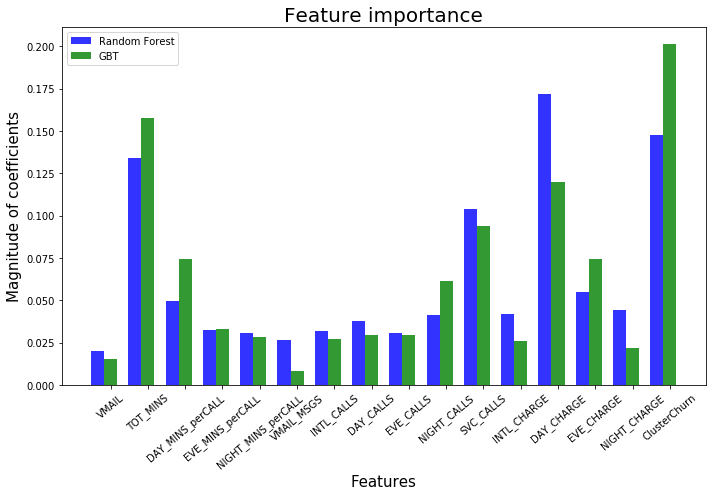

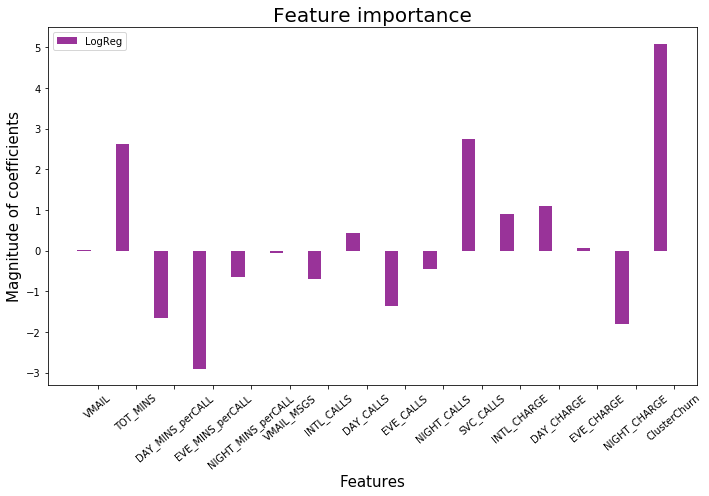

In [30]:
%local

features = ['VMAIL', 'TOT_MINS', 'DAY_MINS_perCALL', 'EVE_MINS_perCALL', 
            'NIGHT_MINS_perCALL', 'VMAIL_MSGS', 'INTL_CALLS', 'DAY_CALLS', 
            'EVE_CALLS', 'NIGHT_CALLS', 'SVC_CALLS', 'INTL_CHARGE', 
            'DAY_CHARGE', 'EVE_CHARGE', 'NIGHT_CHARGE', 'ClusterChurn']

# data to plot
n_groups = len(features)
coeffs_lr = [0.0066, 2.6291, -1.6682, -2.903, -0.6432, -0.0498, -0.7085, 0.4285, -1.3501, -0.454, 2.7493, 0.911, 1.0986, 0.0627, -1.7958, 5.0908]
coeffs_rf = [0.020170175244299003,0.13419959540785925,0.049651174001729435,0.03269901184750684,0.030777434018865707,0.02674864764088476,0.03174909273568973,0.03790594273708081,0.03089763926319225,0.041074140044040475,0.10375098162368908,0.041619851557297825,0.17191445492293522,0.05475233084306841,0.044293391911407666,0.14779613620045343]
coeffs_gbt = [0.015248659738545712,0.1574219102045132,0.07412421503523853,0.033248470805980014,0.028365364741719128,0.00828362145164538,0.02700698513179742,0.029240301288953847,0.02924393528160212,0.061540030409078975,0.09357065125969997,0.025917420771321604,0.11979967731771943,0.07428155330087945,0.02162366743507101,0.20108353582623442]

# define plot
ax, fig=plt.subplots(figsize=(10,7))
index = np.arange(len(features))
bar_width = 0.35
opacity = 0.8

# Bar plot
plt.bar(index, coeffs_rf, bar_width,alpha=opacity,color='b',label='Random Forest')
plt.bar(index + bar_width, coeffs_gbt, bar_width, alpha=opacity,color='g',label='GBT')

plt.xticks(index + bar_width, features, rotation = 40)

# Labels
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients', fontsize=15)
#plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

# Separate plot for logReg because different scale for coefficients

# New figure
ax1, fig1=plt.subplots(figsize=(10,7))
# Bar plot
plt.bar(index, coeffs_lr, bar_width, alpha=opacity, color="purple", label="LogReg")
plt.xticks(index + bar_width, features, rotation = 40)
# Labels
plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients', fontsize=15)
#plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

GBT and Random Forest overwhelmingly use ClusterChurn, DAY_CHARGE and TOT_MINS. Logistic regression also uses SVC_CALLS and EVE_MINS_perCALL. So feature importances differ quantitatively across the three models.

## 5. Assess your model performance on the test set

See what is the final perfomance of your tuned model on unseen data.

In [31]:
# Prepare the test set
assembled_test = assembler_12.transform(prepared_test)

# Select only the label and features columns
labeled_test = assembled_test.select(assembled_test["features"], assembled_test["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Logistic regression__

In [32]:
# Make predictions on test set
pred_test_lr = lrModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy: %.3f" %  evaluator_acc.evaluate(pred_test_lr))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_lr)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# FNR
print("Recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.870
Confusion matrix: 
[['tp: 18' 'fn: 54']
 ['fp: 13' 'tn: 432']]
Recall: 0.250

__Random Forest__

In [33]:
# Make predictions on test set
pred_test_rf = rfModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator_acc.evaluate(pred_test_rf))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_rf)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# Recall
print("recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy = 0.930
Confusion matrix: 
[['tp: 42' 'fn: 30']
 ['fp: 6' 'tn: 439']]
recall: 0.583

__GBT__

In [34]:
# Make predictions on test set
pred_test_gbt = gbtModel.transform(labeled_test)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator_acc.evaluate(pred_test_gbt))

# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test_gbt)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# Recall
print("recall: %.3f" %recall(tp, fn))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy = 0.865
Confusion matrix: 
[['tp: 36' 'fn: 36']
 ['fp: 34' 'tn: 411']]
recall: 0.500

__Model choice__ 

* Logistic regression 

It does clearly not perform as well as the ensemble models. 

* Random Forest 

Execution takes only a couple of seconds. Performs well: high accuracy, few false positives, recall is satisfying i.e above 50%.

* GBT

Hyperparameter tuning can take up to a few minutes. Lower precision and recall than Random Forest, far more false positives than Random Forest.

__=> We keep the model obtained with Random Forest.__

__Gains graph__

Thanks to our models, we now are aware of which customers might resign their contract, so we know which customers to target with a marketing campaign for example.
We can sort customers according to the probability of a positive reaction to the campaign or here according to their churn probability and run the campaign only for a percentage of customers with highest probability.
The Gains chart is the visualization of that principle. 

Here on the X axis we display the targeted percentage of the customer base, ordered by decreasing churn probability. The Y axis gives us the corresponding percentage of all actual churners that have been found in the targeted sample.

In [35]:
pred_test_rf.createOrReplaceTempView("pred_test_rf")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%sql -o pred_test_rf --maxrows -1
SELECT * FROM pred_test_rf

In [37]:
pred_test_lr.createOrReplaceTempView("pred_test_lr")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%sql -o pred_test_lr --maxrows -1
SELECT * FROM pred_test_lr

In [39]:
pred_test_gbt.createOrReplaceTempView("pred_test_gbt")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%sql -o pred_test_gbt --maxrows -1
SELECT * FROM pred_test_gbt

In [41]:
%local 

def gainChart(pred_test):
    
    # Extract the relevant data

    # Predicted proba that label is 1
    proba0 = [x["values"][0] for x in pred_test["probability"]]
    pred_test["proba0"] = pd.Series(proba0)
    sorted_pred_test = pred_test.sort_values(by="proba0").drop(["features", "rawPrediction", "probability"], axis=1)

    sorted_pred_test.head(5)

    # Reset index
    sorted_pred_test_bis = sorted_pred_test.reset_index(drop=True)
    n = len(sorted_pred_test_bis)

    # Add cumulated count for #customers and cumulated frequency for %churners

    #Initialize columns
    sorted_pred_test_bis["#Customers"] = pd.Series([0 for x in range(n)])
    #sorted_pred_test_bis["#predChurners"] = pd.Series([0 for x in range(n)])
    sorted_pred_test_bis["#trueChurners"] = pd.Series([0 for x in range(n)])

    # case i = 0
    sorted_pred_test_bis["#Customers"][0] = 1
    #sorted_pred_test_bis["#predChurners"][0] = sorted_pred_test_bis["prediction"][0]
    sorted_pred_test_bis["#trueChurners"][0] = sorted_pred_test_bis["label"][0]

    # case i>0
    for i in range(1,n):
        sorted_pred_test_bis["#Customers"][i] = i+1
        #sorted_pred_test_bis["#predChurners"][i] = sorted_pred_test_bis["#predChurners"][i-1] + sorted_pred_test_bis["prediction"][i]
        sorted_pred_test_bis["#trueChurners"][i] = sorted_pred_test_bis["#trueChurners"][i-1] + sorted_pred_test_bis["label"][i]

    # Counters as percentages
    m = sum(sorted_pred_test_bis["label"])
    #sorted_pred_test_bis["#predChurners"]/= m  
    sorted_pred_test_bis["#trueChurners"]/= m
    sorted_pred_test_bis["#Customers"] /= n

    
    ## Extract x and y for plot 

    x = sorted_pred_test_bis["#Customers"].values.tolist()
    #y = [sorted_pred_test_bis["#trueChurners"].values.tolist(), sorted_pred_test_bis["#predChurners"].values.tolist()]
    y = sorted_pred_test_bis["#trueChurners"].values.tolist()
    
    return(x,y)

In [42]:
%local
import warnings
warnings.filterwarnings("ignore")

from multiprocessing.dummy import Pool as ThreadPool
# Parallelize tasks
def calculateParallel_xy(dfList, threads=2):
    pool = ThreadPool(threads)
    results = pool.map(gainChart, dfList)
    pool.close()
    pool.join()
    return results

# Compute values
dfList = [pred_test_lr, pred_test_rf, pred_test_gbt]
xy_list = calculateParallel_xy(dfList, 4)
[(x_lr, y_lr), (x_rf, y_rf), (x_gbt, y_gbt)] = xy_list

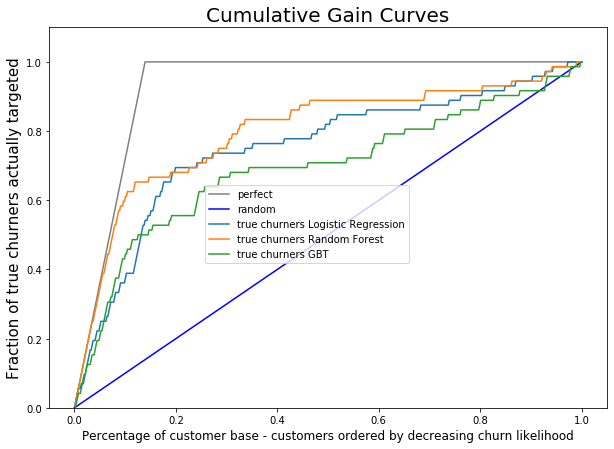

In [43]:
%local

## Plot all the curves on the same graph

m = sum(pred_test_lr["label"])
n = len(pred_test_lr)

ax, fig=plt.subplots(figsize=(10,7))
    
x_random = [0,1]
y_random = [0,1]

x_perfect = [0,m/n,1]
y_perfect = [0,1,1]

plt.ylim((0, 1.1)) 

plt.plot(x_perfect, y_perfect, color = 'grey', label = "perfect")
plt.plot(x_random, y_random, color = 'b', label = "random")

plt.plot(x_lr, y_lr, label="true churners Logistic Regression")
plt.plot(x_rf, y_rf, label="true churners Random Forest")
plt.plot(x_gbt, y_gbt, label="true churners GBT")
    
    
plt.xlabel('Percentage of customer base - customers ordered by decreasing churn likelihood', fontsize=12)
plt.ylabel('Fraction of true churners actually targeted', fontsize=15)
ax.legend(loc='center')
plt.title('Cumulative Gain Curves', fontsize=20)

plt.show()    

If we target 20 % of the customers which are the most likely to be churners, we are able to reach over 70% of all real churners with Random Forest. Beyond this point improvements come slower.

## 6. Save the results for deployment

Optional : if you want to take a final look at your models' parameters before saving them.

In [44]:
#print("KMeans parameters:\n" + kmeans.explainParams() + "\n")
#print("Logistic Regression parameters:\n" + logReg.explainParams() + "\n")
#print("Random Forest parameters:\n" + rf.explainParams() + "\n")
#print("Gradient Boosted Trees parameters:\n" + gbt.explainParams() + "\n")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Method 1 : Extract parameter map__

First, save the parameter map of each model. Then, create a new model and use algo.fit(training_set, saved_param). Here is an example with KMeans.

In [45]:
# Example with kmeans 

# Extract parameter map
kmeansParamMap = clusterModel.extractParamMap()
print("KMeans Model was fit using parameters: ")
print(kmeansParamMap)
# Define a new model with the same parameter map
kmeans2 = kmeans.fit(train_16, kmeansParamMap)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KMeans Model was fit using parameters: 
{Param(parent='KMeans_496aa548ff1282ce3b31', name='featuresCol', doc='features column name'): 'features', Param(parent='KMeans_496aa548ff1282ce3b31', name='initMode', doc="The initialization algorithm. Supported options: 'random' and 'k-means||'."): 'k-means||', Param(parent='KMeans_496aa548ff1282ce3b31', name='initSteps', doc='The number of steps for k-means|| initialization mode. Must be > 0.'): 2, Param(parent='KMeans_496aa548ff1282ce3b31', name='k', doc='The number of clusters to create. Must be > 1.'): 15, Param(parent='KMeans_496aa548ff1282ce3b31', name='maxIter', doc='maximum number of iterations (>= 0)'): 20, Param(parent='KMeans_496aa548ff1282ce3b31', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='KMeans_496aa548ff1282ce3b31', name='seed', doc='random seed'): 1, Param(parent='KMeans_496aa548ff1282ce3b31', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0)'): 0.0001}

However this is not the most practical way of saving your models. Let's save them directly as separate files.

__Method 2 : Save models as files__

We have already seved our scaler model in the first notebook. Here we save the best model and the KMeans model. We will use them all in the last notebook which is focused on deployment.

In [46]:
# just use model.save("path") if there is no name conflict
# feel free to adapt the path 

clusterModel.write().overwrite().save("/tmp/myClusterModel")
rfModel.write().overwrite().save("/tmp/myRFModel")

# If you also want to test deployment with other models:
#lrModel.write().overwrite().save("/tmp/myLogRegModel")
#gbtModel.write().overwrite().save("/tmp/myGBTModel")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## What you've learned

Congratulations!

Through this notebook, you've learned how to:

* use PySpark for a classic workflow, from data preparation to model assessment
* build models using both supervised and unsupervised learning
* compute and visualize useful indicators in order to evaluate a model
* save a model for future use.

____
## Authors

Eva Feillet - ML intern, IBM Cloud and Cognitive Software, IBM Lab in Böblingen, Germany